强化学习在运动规划方面也有很大的应用前景，具体包括路径规划与决策，智能派单等等，本次项目就将单体运动规划抽象并简化，让大家初步认识到强化学习在这方面的应用。在运动规划方面，其实已有很多适用于强化学习的仿真环境，小到迷宫，大到贴近真实的自动驾驶环境[CARLA](http://carla.org/)，对这块感兴趣的童鞋可以再多搜集一点。本项目采用gym开发的CliffWalking-v0环境，在上面实现一个简单的Q-learning入门demo。



# CliffWalking-v0环境简介
首先对该环境做一个简介，该环境中文名称叫悬崖寻路问题（CliffWalking），是指在一个4 x 12的网格中，智能体以网格的左下角位置为起点，以网格的下角位置为终点，目标是移动智能体到达终点位置，智能体每次可以在上、下、左、右这4个方向中移动一步，每移动一步会得到-1单位的奖励。

![image.png](https://datawhalechina.github.io/easy-rl/chapter3/assets/cliffwalking_1.png)

如图，红色部分表示悬崖，数字代表智能体能够观测到的位置信息，即observation，总共会有0-47等48个不同的值，智能体再移动中会有以下限制：

    智能体不能移出网格，如果智能体想执行某个动作移出网格，那么这一步智能体不会移动，但是这个操作依然会得到-1单位的奖励

    如果智能体“掉入悬崖” ，会立即回到起点位置，并得到-100单位的奖励

    当智能体移动到终点时，该回合结束，该回合总奖励为各步奖励之和

实际的仿真界面如下：
   ![img](https://datawhalechina.github.io/easy-rl/chapter3/assets/cliffwalking_2.png)

由于从起点到终点最少需要13步，每步得到-1的reward，因此最佳训练算法下，每个episode下reward总和应该为-13。所以我们的目标也是要通过RL训练出一个模型，使得该模型能在测试中一个episode的reward能够接近于-13左右。

# RL基本训练接口

以下是强化学习算法的基本接口，也就是一个完整的上层训练模式，首先是初始化环境和智能体，然后每个episode中，首先agent选择action给到环境，然后环境反馈出下一个状态和reward，然后agent开始更新或者学习，如此多个episode之后agent开始收敛并保存模型。其中可以通过可视化reward随每个episode的变化来查看训练的效果。另外由于强化学习的不稳定性，在收敛的状态下也可能会有起伏的情况，此时可以使用滑动平均的reward让曲线更加平滑便于分析。

## 建立环境

In [9]:
## 
import gym
import turtle
import numpy as np

# turtle tutorial : https://docs.python.org/3.3/library/turtle.html


def GridWorld(gridmap=None, is_slippery=False):
    if gridmap is None:
        gridmap = ['SFFF', 'FHFH', 'FFFH', 'HFFG']
    env = gym.make("FrozenLake-v0", desc=gridmap, is_slippery=False)
    env = FrozenLakeWapper(env)
    return env


class FrozenLakeWapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.max_y = env.desc.shape[0]
        self.max_x = env.desc.shape[1]
        self.t = None
        self.unit = 50

    def draw_box(self, x, y, fillcolor='', line_color='gray'):
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.color(line_color)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for _ in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        self.t.up()
        self.t.setheading(90)
        self.t.fillcolor('red')
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)

    def render(self):
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape('circle')
            self.t.width(2)
            self.t.speed(0)
            self.t.color('gray')
            for i in range(self.desc.shape[0]):
                for j in range(self.desc.shape[1]):
                    x = j
                    y = self.max_y - 1 - i
                    if self.desc[i][j] == b'S':  # Start
                        self.draw_box(x, y, 'white')
                    elif self.desc[i][j] == b'F':  # Frozen ice
                        self.draw_box(x, y, 'white')
                    elif self.desc[i][j] == b'G':  # Goal
                        self.draw_box(x, y, 'yellow')
                    elif self.desc[i][j] == b'H':  # Hole
                        self.draw_box(x, y, 'black')
                    else:
                        self.draw_box(x, y, 'white')
            self.t.shape('turtle')

        x_pos = self.s % self.max_x
        y_pos = self.max_y - 1 - int(self.s / self.max_x)
        self.move_player(x_pos, y_pos)


class CliffWalkingWapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.t = None
        self.unit = 50
        self.max_x = 12
        self.max_y = 4

    def draw_x_line(self, y, x0, x1, color='gray'):
        assert x1 > x0
        self.t.color(color)
        self.t.setheading(0)
        self.t.up()
        self.t.goto(x0, y)
        self.t.down()
        self.t.forward(x1 - x0)

    def draw_y_line(self, x, y0, y1, color='gray'):
        assert y1 > y0
        self.t.color(color)
        self.t.setheading(90)
        self.t.up()
        self.t.goto(x, y0)
        self.t.down()
        self.t.forward(y1 - y0)

    def draw_box(self, x, y, fillcolor='', line_color='gray'):
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.color(line_color)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for i in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        self.t.up()
        self.t.setheading(90)
        self.t.fillcolor('red')
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)

    def render(self):
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape('circle')
            self.t.width(2)
            self.t.speed(0)
            self.t.color('gray')
            for _ in range(2):
                self.t.forward(self.max_x * self.unit)
                self.t.left(90)
                self.t.forward(self.max_y * self.unit)
                self.t.left(90)
            for i in range(1, self.max_y):
                self.draw_x_line(
                    y=i * self.unit, x0=0, x1=self.max_x * self.unit)
            for i in range(1, self.max_x):
                self.draw_y_line(
                    x=i * self.unit, y0=0, y1=self.max_y * self.unit)

            for i in range(1, self.max_x - 1):
                self.draw_box(i, 0, 'black')
            self.draw_box(self.max_x - 1, 0, 'yellow')
            self.t.shape('turtle')

        x_pos = self.s % self.max_x
        y_pos = self.max_y - 1 - int(self.s / self.max_x)
        self.move_player(x_pos, y_pos)


if __name__ == '__main__':
    # 环境1：FrozenLake, 可以配置冰面是否是滑的
    # 0 left, 1 down, 2 right, 3 up
    env = gym.make("FrozenLake-v1", is_slippery=False)
    env = FrozenLakeWapper(env)

    # 环境2：CliffWalking, 悬崖环境
    # env = gym.make("CliffWalking-v0")  # 0 up, 1 right, 2 down, 3 left
    # env = CliffWalkingWapper(env)

    # 环境3：自定义格子世界，可以配置地图, S为出发点Start, F为平地Floor, H为洞Hole, G为出口目标Goal
    # gridmap = [
    #         'SFFF',
    #         'FHFF',
    #         'FFFF',
    #         'HFGF' ]
    # env = GridWorld(gridmap)

    env.reset()
    for step in range(10):
        action = np.random.randint(0, 4)
        obs, reward, done, info = env.step(action)
        print('step {}: action {}, obs {}, reward {}, done {}, info {}'.format(\
                step, action, obs, reward, done, info))
        # env.render() # 渲染一帧图像

step 0: action 3, obs 0, reward 0.0, done False, info {'prob': 1.0}
step 1: action 3, obs 0, reward 0.0, done False, info {'prob': 1.0}
step 2: action 1, obs 4, reward 0.0, done False, info {'prob': 1.0}
step 3: action 0, obs 4, reward 0.0, done False, info {'prob': 1.0}
step 4: action 1, obs 8, reward 0.0, done False, info {'prob': 1.0}
step 5: action 3, obs 4, reward 0.0, done False, info {'prob': 1.0}
step 6: action 0, obs 4, reward 0.0, done False, info {'prob': 1.0}
step 7: action 1, obs 8, reward 0.0, done False, info {'prob': 1.0}
step 8: action 0, obs 8, reward 0.0, done False, info {'prob': 1.0}
step 9: action 3, obs 4, reward 0.0, done False, info {'prob': 1.0}


## 定义Q Learning Model

In [4]:
import numpy as np
import math
import torch
from collections import defaultdict

In [5]:
class QLearning(object):
    def __init__(self,n_states,n_actions,cfg): # 状态数，动作数，超参数配置
        self.n_actions = n_actions 
        self.lr = cfg.lr  # 学习率
        self.gamma = cfg.gamma  
        self.epsilon = 0 
        self.sample_count = 0  
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.Q_table  = defaultdict(lambda: np.zeros(n_actions)) # 用嵌套字典存放状态->动作->状态-动作值（Q值）的映射，即Q表
    def choose_action(self, state):
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) # epsilon是会递减的，这里选择指数递减
        # e-greedy 策略
        if np.random.uniform(0, 1) > self.epsilon:
            action = np.argmax(self.Q_table[str(state)]) # 选择Q(s,a)最大对应的动作
        else:
            action = np.random.choice(self.n_actions) # 随机选择动作
        return action
    def predict(self,state):
        action = np.argmax(self.Q_table[str(state)])
        return action
    def update(self, state, action, reward, next_state, done):
        Q_predict = self.Q_table[str(state)][action] 
        if done: # 终止状态
            Q_target = reward  
        else:
            Q_target = reward + self.gamma * np.max(self.Q_table[str(next_state)]) 
        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict)
    def save(self,path):
        import dill
        torch.save(
            obj=self.Q_table,
            f=path+"Qleaning_model.pkl",
            pickle_module=dill
        )
        print("保存模型成功！")
    def load(self, path):
        import dill
        self.Q_table =torch.load(f=path+'Qleaning_model.pkl',pickle_module=dill)
        print("加载模型成功！")

## 开始训练与测试

In [15]:
import sys
import os
__file__ = "/Users/xiejianghuangchao/Downloads/XXX.ipynb"
curr_path = os.path.dirname(os.path.abspath(__file__))  # 当前文件所在绝对路径
parent_path = os.path.dirname(curr_path)  # 父路径
#sys.path.append(parent_path)  # 添加路径到系统路径

import gym
import torch
import datetime

#from env.gridworld_env import CliffWalkingWapper
#from qlearning import QLearning
from common.utils import plot_rewards
from common.utils import save_results,make_dir

curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # 获取当前时间

print(curr_path, curr_time)

/Users/xiejianghuangchao/Downloads 20220716-000600


开始训练！
环境:CliffWalking-v0, 算法:Q-learning, 设备:cpu
回合数：1/400，奖励-3631.0
回合数：2/400，奖励-199.0
回合数：3/400，奖励-186.0
回合数：4/400，奖励-246.0
回合数：5/400，奖励-188.0
回合数：6/400，奖励-149.0
回合数：7/400，奖励-104.0
回合数：8/400，奖励-166.0
回合数：9/400，奖励-135.0
回合数：10/400，奖励-105.0
回合数：11/400，奖励-157.0
回合数：12/400，奖励-92.0
回合数：13/400，奖励-100.0
回合数：14/400，奖励-165.0
回合数：15/400，奖励-67.0
回合数：16/400，奖励-215.0
回合数：17/400，奖励-55.0
回合数：18/400，奖励-155.0
回合数：19/400，奖励-118.0
回合数：20/400，奖励-30.0
回合数：21/400，奖励-183.0
回合数：22/400，奖励-159.0
回合数：23/400，奖励-66.0
回合数：24/400，奖励-100.0
回合数：25/400，奖励-115.0
回合数：26/400，奖励-53.0
回合数：27/400，奖励-350.0
回合数：28/400，奖励-85.0
回合数：29/400，奖励-102.0
回合数：30/400，奖励-77.0
回合数：31/400，奖励-61.0
回合数：32/400，奖励-108.0
回合数：33/400，奖励-67.0
回合数：34/400，奖励-65.0
回合数：35/400，奖励-71.0
回合数：36/400，奖励-73.0
回合数：37/400，奖励-110.0
回合数：38/400，奖励-69.0
回合数：39/400，奖励-27.0
回合数：40/400，奖励-56.0
回合数：41/400，奖励-52.0
回合数：42/400，奖励-105.0
回合数：43/400，奖励-64.0
回合数：44/400，奖励-58.0
回合数：45/400，奖励-60.0
回合数：46/400，奖励-72.0
回合数：47/400，奖励-71.0
回合数：48/400，奖励-41.0
回合数：49/400，奖励-55.0
回合数：

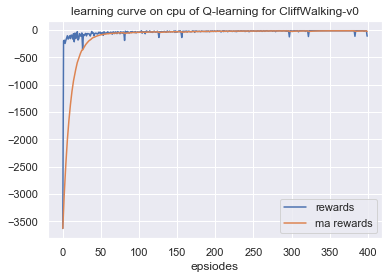

加载模型成功！
开始测试！
环境：CliffWalking-v0, 算法：Q-learning, 设备：cpu
回合数：1/30, 奖励：-13.0
回合数：2/30, 奖励：-13.0
回合数：3/30, 奖励：-13.0
回合数：4/30, 奖励：-13.0
回合数：5/30, 奖励：-13.0
回合数：6/30, 奖励：-13.0
回合数：7/30, 奖励：-13.0
回合数：8/30, 奖励：-13.0
回合数：9/30, 奖励：-13.0
回合数：10/30, 奖励：-13.0
回合数：11/30, 奖励：-13.0
回合数：12/30, 奖励：-13.0
回合数：13/30, 奖励：-13.0
回合数：14/30, 奖励：-13.0
回合数：15/30, 奖励：-13.0
回合数：16/30, 奖励：-13.0
回合数：17/30, 奖励：-13.0
回合数：18/30, 奖励：-13.0
回合数：19/30, 奖励：-13.0
回合数：20/30, 奖励：-13.0
回合数：21/30, 奖励：-13.0
回合数：22/30, 奖励：-13.0
回合数：23/30, 奖励：-13.0
回合数：24/30, 奖励：-13.0
回合数：25/30, 奖励：-13.0
回合数：26/30, 奖励：-13.0
回合数：27/30, 奖励：-13.0
回合数：28/30, 奖励：-13.0
回合数：29/30, 奖励：-13.0
回合数：30/30, 奖励：-13.0
完成测试！
Result saved!


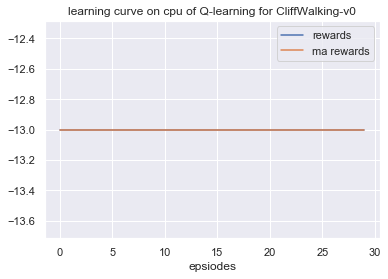

In [22]:
class Config:
    '''超参数
    '''

    def __init__(self):
        ################################## 环境超参数 ###################################
        self.algo_name = 'Q-learning'  # 算法名称
        self.env_name = 'CliffWalking-v0'  # 环境名称
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")  # 检测GPUgjgjlkhfsf风刀霜的撒发十
        self.seed = 10 # 随机种子，置0则不设置随机种子
        self.train_eps = 400  # 训练的回合数
        self.test_eps = 30  # 测试的回合数
        ################################################################################
        
        ################################## 算法超参数 ###################################
        self.gamma = 0.90  # 强化学习中的折扣因子
        self.epsilon_start = 0.95  # e-greedy策略中初始epsilon
        self.epsilon_end = 0.01  # e-greedy策略中的终止epsilon
        self.epsilon_decay = 300  # e-greedy策略中epsilon的衰减率
        self.lr = 0.1  # 学习率
        ################################################################################
        
        ################################# 保存结果相关参数 ################################
        self.result_path = curr_path + "/outputs/" + self.env_name + \
            '/' + curr_time + '/results/'  # 保存结果的路径
        self.model_path = curr_path + "/outputs/" + self.env_name + \
            '/' + curr_time + '/models/'  # 保存模型的路径
        self.save_fig = True # 是否保存图片
        ################################################################################
        
def train(cfg,env,agent):
    print('开始训练！')
    print(f'环境:{cfg.env_name}, 算法:{cfg.algo_name}, 设备:{cfg.device}')
    rewards = []  # 记录奖励
    ma_rewards = [] # 记录滑动平均奖励
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录每个回合的奖励
        state = env.reset()  # 重置环境,即开始新的回合
        while True:
            action = agent.choose_action(state)  # 根据算法选择一个动作
            next_state, reward, done, _ = env.step(action)  # 与环境进行一次动作交互
            agent.update(state, action, reward, next_state, done)  # Q学习算法更新
            state = next_state  # 更新状态
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+ep_reward*0.1)
        else:
            ma_rewards.append(ep_reward)
        print("回合数：{}/{}，奖励{:.1f}".format(i_ep+1, cfg.train_eps,ep_reward))
    print('完成训练！')
    return rewards,ma_rewards
    
def test(cfg,env,agent):
    print('开始测试！')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    rewards = []  # 记录所有回合的奖励
    ma_rewards = [] # 滑动平均的奖励
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录每个episode的reward
        state = env.reset()  # 重置环境, 重新开一局（即开始新的一个回合）
        while True:
            action = agent.predict(state)  # 根据算法选择一个动作
            next_state, reward, done, _ = env.step(action)  # 与环境进行一个交互
            state = next_state  # 更新状态
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+ep_reward*0.1)
        else:
            ma_rewards.append(ep_reward)
        print(f"回合数：{i_ep+1}/{cfg.test_eps}, 奖励：{ep_reward:.1f}")
    print('完成测试！')
    return rewards,ma_rewards
        
def env_agent_config(cfg,seed=1):
    '''创建环境和智能体
    Args:
        cfg ([type]): [description]
        seed (int, optional): 随机种子. Defaults to 1.
    Returns:
        env [type]: 环境
        agent : 智能体
    '''    
    env = gym.make(cfg.env_name)  
    env = CliffWalkingWapper(env)
    env.seed(seed) # 设置随机种子
    n_states = env.observation_space.n # 状态维度
    n_actions = env.action_space.n # 动作维度
    agent = QLearning(n_states,n_actions,cfg)
    return env,agent
if __name__ == "__main__":
    cfg = Config()
    # 训练
    env, agent = env_agent_config(cfg, seed=1)
    rewards, ma_rewards = train(cfg, env, agent)
    make_dir(cfg.result_path, cfg.model_path)  # 创建保存结果和模型路径的文件夹
    agent.save(path=cfg.model_path)  # 保存模型
    save_results(rewards, ma_rewards, tag='train',
                path=cfg.result_path)  # 保存结果
    plot_rewards(rewards, ma_rewards, cfg, tag="train")  # 画出结果
    # 测试
    env, agent = env_agent_config(cfg, seed=10)
    agent.load(path=cfg.model_path)  # 导入模型
    rewards, ma_rewards = test(cfg, env, agent)
    save_results(rewards, ma_rewards, tag='test', path=cfg.result_path)  # 保存结果
    plot_rewards(rewards, ma_rewards, cfg, tag="test")  # 画出结果

In [28]:
#
'''初始化环境'''  
env = gym.make("CliffWalking-v0")  # 0 up, 1 right, 2 down, 3 left
env = CliffWalkingWapper(env)
cfg = Config()
agent = QLearning(
    n_states=env.observation_space.n,
    n_actions=env.action_space.n,
    cfg=cfg
    )
rewards = []  
ma_rewards = [] # moving average reward
for i_ep in range(cfg.train_eps): # train_eps: 训练的最大episodes数
    ep_reward = 0  # 记录每个episode的reward
    state = env.reset()  # 重置环境, 重新开一局（即开始新的一个episode）
    while True:
        action = agent.choose_action(state)  # 根据算法选择一个动作
        next_state, reward, done, _ = env.step(action)  # 与环境进行一次动作交互
        agent.update(state, action, reward, next_state, done)  # Q-learning算法更新
        state = next_state  # 存储上一个观察值
        ep_reward += reward
        if done:
            break
    rewards.append(ep_reward)
    if ma_rewards:
        ma_rewards.append(ma_rewards[-1]*0.9+ep_reward*0.1)
    else:
        ma_rewards.append(ep_reward)
    print("Episode:{}/{}: reward:{:.1f}".format(i_ep+1, cfg.train_eps,ep_reward))


Episode:1/400: reward:-1076.0
Episode:2/400: reward:-2979.0
Episode:3/400: reward:-251.0
Episode:4/400: reward:-181.0
Episode:5/400: reward:-296.0
Episode:6/400: reward:-211.0
Episode:7/400: reward:-184.0
Episode:8/400: reward:-93.0
Episode:9/400: reward:-305.0
Episode:10/400: reward:-148.0
Episode:11/400: reward:-75.0
Episode:12/400: reward:-204.0
Episode:13/400: reward:-60.0
Episode:14/400: reward:-138.0
Episode:15/400: reward:-104.0
Episode:16/400: reward:-128.0
Episode:17/400: reward:-137.0
Episode:18/400: reward:-103.0
Episode:19/400: reward:-64.0
Episode:20/400: reward:-131.0
Episode:21/400: reward:-125.0
Episode:22/400: reward:-89.0
Episode:23/400: reward:-70.0
Episode:24/400: reward:-237.0
Episode:25/400: reward:-81.0
Episode:26/400: reward:-95.0
Episode:27/400: reward:-32.0
Episode:28/400: reward:-110.0
Episode:29/400: reward:-106.0
Episode:30/400: reward:-60.0
Episode:31/400: reward:-63.0
Episode:32/400: reward:-124.0
Episode:33/400: reward:-48.0
Episode:34/400: reward:-91.0


Episode:382/400: reward:-13.0
Episode:383/400: reward:-13.0
Episode:384/400: reward:-13.0
Episode:385/400: reward:-13.0
Episode:386/400: reward:-13.0
Episode:387/400: reward:-13.0
Episode:388/400: reward:-13.0
Episode:389/400: reward:-13.0
Episode:390/400: reward:-13.0
Episode:391/400: reward:-13.0
Episode:392/400: reward:-13.0
Episode:393/400: reward:-13.0
Episode:394/400: reward:-13.0
Episode:395/400: reward:-13.0
Episode:396/400: reward:-13.0
Episode:397/400: reward:-13.0
Episode:398/400: reward:-13.0
Episode:399/400: reward:-13.0
Episode:400/400: reward:-13.0
